In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from tqdm import tqdm

import wandb
from precip.config import CONVLSTM_MODEL_CONFIG, BOUNDARY_CLASSIFICATION_LABEL, LOCAL_PRECIP_DATA_AVERAGES
from precip.data.dataset import SwedishPrecipitationDataset
from precip.models.conv_lstm.model import ConvLSTM, ConvLSTMCell

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="precip",
#     # track hyperparameters and run metadata
#     config=CONVLSTM_MODEL_CONFIG.__dict__,
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# class Model(nn.Module):
#     def __init__(self, input_channels, hidden_channels, kernel_size, num_layers) -> None:
#         super().__init__()

#         self.lstm_model = ConvLSTM(
#             input_channel=input_channels,
#             hidden_channel=hidden_channels,
#             kernel_size=kernel_size,
#             num_layers=num_layers,
#             batch_first=True,
#             return_all_layers=False,
#         )
#         self.out_conv = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=1)

#     def forward(self, x):
#         _, x = self.lstm_model(x)
#         return self.out_conv(x[0][0]).squeeze(1)
    

# class ModelDiscretizedOutput(nn.Module):
#     def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, mask: torch.Tensor, upscale: float = 255) -> None:
#         super().__init__()

#         self.lstm_model = ConvLSTM(
#             input_channel=input_channels,
#             hidden_channel=hidden_channels,
#             kernel_size=kernel_size,
#             num_layers=num_layers,
#             batch_first=True,
#             return_all_layers=False,
#         )
#         self.out_conv = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=1)
#         self.upscale = upscale
#         self.mask = mask

#     def forward(self, x):
#         _, x = self.lstm_model(x)
#         x = self.out_conv(x[0][0]).squeeze(1)
#         x *= self.upscale  # move from [0, 1] back to [0, 255]
#         x = x.int()
#         x = torch.where(~self.mask.to(device), x, BOUNDARY_CLASSIFICATION_LABEL)
#         return x




def delete(arr: torch.Tensor, ind: int, dim: int) -> torch.Tensor:
    skip = [i for i in range(arr.size(dim)) if i != ind]
    indices = [slice(None) if i != dim else skip for i in range(arr.ndim)]
    return arr.__getitem__(indices)



class ModelDiscretizedOutput(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, mask: torch.Tensor, upscale: float = 255) -> None:
        super().__init__()

        self.lstm_model = ConvLSTM(
            input_channel=input_channels,
            hidden_channel=hidden_channels,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,
            return_all_layers=False,
        )
        self.out_conv = nn.ConvTranspose2d(64, 256, kernel_size=(3, 3), padding=1)
        self.upscale = upscale
        self.mask = mask
        
        self.boundary_slice_index = 255
        self.non_boundary_slice_indices = list(range(0, 256)).remove(255)

    def forward(self, x):
        _, x = self.lstm_model(x)
        x = self.out_conv(x[0][0]).squeeze(1)

        # for the boundary, directly set probability
        x[:, self.boundary_slice_index, ...] = torch.where(~self.mask.to(device), x[:, self.boundary_slice_index, ...], torch.inf)
        x[:, self.non_boundary_slice_indices, ...] = torch.where(~self.mask.to(device), x[:, self.non_boundary_slice_indices , ...], -1*torch.inf)
        return x

training_dataset = SwedishPrecipitationDataset(split="train", scale=True)
validation_dataset = SwedishPrecipitationDataset(split="val", scale=True)

dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True, num_workers=12)
val_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=True, num_workers=12)



# model = Model(input_channels=1, hidden_channels=[64], kernel_size=(3, 3), num_layers=1).to(
#     device
# )

# loss = nn.MSELoss()
# optimizer = optim.Adam(
#     model.parameters(),
#     lr=CONVLSTM_MODEL_CONFIG.lr,
#     weight_decay=CONVLSTM_MODEL_CONFIG.weight_decay,
# )
# scheduler = optim.lr_scheduler.ExponentialLR(
#     optimizer, gamma=CONVLSTM_MODEL_CONFIG.lr_scheduler_gamma
# )

# def train():
#     model.train()
#     loss_history = list()

#     for batch_index, (batch_X, batch_y) in tqdm(enumerate(dataloader), total=len(dataloader)):
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         out = model(batch_X)
#         _loss = loss(out, batch_y)
#         _loss.backward()
#         optimizer.step()

#         if batch_index % 10 == 0:
#             loss_history.append(_loss.item())

#     return loss_history

# @torch.no_grad()
# def test():
#     model.eval()
#     validation_loss_history = list()

#     for _, (batch_X, batch_y) in enumerate(val_dataloader):
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         out = model(batch_X)
#         validation_loss_history.append(loss(out, batch_y).item())
#     return validation_loss_history


In [3]:
for batch_index, (batch_X, batch_y) in tqdm(enumerate(dataloader), total=len(dataloader)):
    break

  0%|          | 0/2470 [00:00<?, ?it/s]


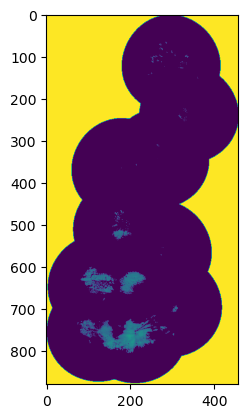

In [4]:
plt.imshow(batch_X[1, 2, 0].numpy())

In [5]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

mask = npy_loader('/home/tom/local_data/sweden_precip_observation_boundaries.npy')
averages = npy_loader(LOCAL_PRECIP_DATA_AVERAGES)

model = ModelDiscretizedOutput(input_channels=1, hidden_channels=[64], kernel_size=(3, 3), num_layers=1, mask=mask.to(device)).to(
    device
)

In [6]:
y = model(batch_X.to(device))

In [8]:
batch_y

tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]])